This notebook implements a Transformer-based architecture ("GeneBERT") to classify biological samples based on their gene expression profiles. Unlike traditional machine learning models (SVM, Random Forest), this approach leverages deep learning to capture complex, non-linear interactions within high-dimensional genetic data.

In [1]:
!pip install opendatasets

### Data Preprocessing: Out-of-Core Data Alignment

The following code block performs the ETL (Extract, Transform, Load) process to create the final **(merged_gene_data.csv)**. Given the high dimensionality of genomic data, loading all datasets simultaneously would likely exceed Google Colab's available RAM. To mitigate this, we utilize an **out-of-core** processing strategy with the following specific techniques:

1.  **Global Feature Alignment:**
    We first perform a lightweight scan of all files to identify the **union** of all gene IDs. This ensures that every sample in the final dataset has the exact same feature columns, regardless of which file it originated from.

2.  **Sparse Reindexing:**
    When processing individual files, we use `.reindex()` to align the local samples to the global master gene list. Any missing gene values are filled with `0.0` (zero-padding), preserving the structural integrity of the matrix.

3.  **Memory Optimization:**
    * **Incremental Write:** Instead of concatenating DataFrames in RAM, we append chunks to the disk (`mode='a'`) and immediately release memory using `gc.collect()`.
    * **Type Downcasting:** Data is converted to `float32` (single precision). This is sufficient for normalized gene counts and **halves the memory footprint** compared to the default `float64`.


In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import opendatasets as od
import gc  

dataset_url = 'https://www.kaggle.com/datasets/abdulbasit20062002/train-scienta-lab-interview-project'
try:
    od.download(dataset_url)
except Exception:
    pass

DATA_PATH = './train-scienta-lab-interview-project'
OUTPUT_FILE = 'merged_gene_data.csv'


def memory_efficient_merge(path, output_filename):
    files = glob.glob(os.path.join(path, '*.tsv'))

    #  Build Master Gene List (Lightweight Scan) ---
    print("Phase 1: Scanning files to build Master Gene List...")
    all_genes_set = set()
    for f in files:
        try:
            # Read only the index (Gene Names)
            df_iter = pd.read_csv(f, sep='\t', index_col=0, usecols=[0])
            all_genes_set.update(df_iter.index.tolist())
            del df_iter
            gc.collect()
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    master_gene_list = sorted(list(all_genes_set))
    num_genes = len(master_gene_list)
    print(f"Total Unique Genes: {num_genes}")

    # Initialize Output CSV 
    # We write the Header row first
    # Header: Gene1, Gene2, ... GeneN, label
    header = master_gene_list + ['label']
    pd.DataFrame(columns=header).to_csv(output_filename, index=True, index_label="sample_id")

    #  Stream Processing (One File at a Time) ---
    print("Phase 2: Processing and Appending files...")

    # Variables for Global Stats
    global_max = -np.inf
    global_min = np.inf
    total_zeros = 0
    total_elements = 0
    class_counts = {0: 0, 1: 0, 2: 0}
    total_samples = 0

    for f in files:
        fname = os.path.basename(f)
        print(f"  > Processing {fname}...")

        try:
            # 1. Load Data
            df = pd.read_csv(f, sep='\t', index_col=0).T # Rows=Samples

            # 2. Determine Label
            if "healthy" in fname.lower():
                label = 0
            elif "ra_" in fname.lower():
                label = 1
            elif "sle_" in fname.lower():
                label = 2
            else:
                print(f"    WARNING: Skipping {fname} (Unknown Class)")
                continue

            #  Align Columns (Zero Padding)
            # Efficient Reindex
            df = df.reindex(columns=master_gene_list, fill_value=0.0)

            #  MEMORY TRICK: Downcast to Float32 (Saves 50% RAM)
            df = df.astype('float32')

            #  Add Label
            df['label'] = label

            #  Update Stats (On the fly)
            current_vals = df.drop(columns=['label']).values
            global_max = max(global_max, np.nanmax(current_vals))
            global_min = min(global_min, np.nanmin(current_vals))
            total_zeros += (current_vals == 0).sum()
            total_elements += current_vals.size
            class_counts[label] += len(df)
            total_samples += len(df)

            # Append to Disk immediately
            # mode='a' (append), header=False (header already written)
            df.to_csv(output_filename, mode='a', header=False)

            #  Clean up RAM immediately
            del df
            del current_vals
            gc.collect()

        except Exception as e:
            print(f"Error processing {fname}: {e}")

    return {
        "num_genes": num_genes,
        "num_samples": total_samples,
        "sparsity": total_zeros / total_elements if total_elements > 0 else 0,
        "min_val": global_min,
        "max_val": global_max,
        "class_counts": class_counts
    }


stats = memory_efficient_merge(DATA_PATH, OUTPUT_FILE)

if stats:
    print("\n" + "="*40)
    print("FINAL DATA REPORT (Memory Efficient Mode)")
    print("="*40)
    print(f"1. Final Input Dimension (Genes):   {stats['num_genes']}")
    print(f"2. Total Samples (Batch Size):      {stats['num_samples']}")
    print(f"3. Data Sparsity (Zeros %):         {stats['sparsity']:.2%}")
    print(f"4. Value Range:                     {stats['min_val']:.2f} to {stats['max_val']:.2f}")
    print(f"5. Class Distribution:")
    print(f"   - Class 0 (Healthy): {stats['class_counts'].get(0, 0)}")
    print(f"   - Class 1 (RA):      {stats['class_counts'].get(1, 0)}")
    print(f"   - Class 2 (SLE):     {stats['class_counts'].get(2, 0)}")
    print("="*40)
    print(f"Data successfully saved to: {OUTPUT_FILE}")
else:
    print("Merge failed.")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abdulbasit20062002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdulbasit20062002/train-scienta-lab-interview-project


100%|██████████| 128M/128M [00:00<00:00, 1.39GB/s]

Phase 1: Scanning files to build Master Gene List...
Total Unique Genes: 3221
Phase 2: Processing and Appending files...
  > Processing healthy_train_data.tsv...
  > Processing ra_train_data.tsv...
  > Processing sle_train_data.tsv...

FINAL DATA REPORT (Memory Efficient Mode)
1. Final Input Dimension (Genes):   3221
2. Total Samples (Batch Size):      99785
3. Data Sparsity (Zeros %):         88.13%
4. Value Range:                     0.00 to 852100.00
5. Class Distribution:
   - Class 0 (Healthy): 24403
   - Class 1 (RA):      37691
   - Class 2 (SLE):     37691
Data successfully saved to: merged_gene_data.csv


### "GeneBERT" Architecture

We adapt the Transformer architecture for tabular data:

Feature Projection: A Linear layer projects the high-dimensional input (genes) into a dense embedding space (128 dim).

Transformer Encoder: We utilize nn.TransformerEncoder. While Transformers are typically used for sequences (like text), applying them here allows the model to learn complex representations via self-attention mechanisms and feed-forward networks with residual connections.

Classification Head: A final MLP projects the learned representations to the number of target classes.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import gc

# Config
FILE_PATH = "merged_gene_data.csv"
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 10
EMBED_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
NUM_CLASSES = 3

# Data Loading
print("--- Loading Data Safely (Chunk by Chunk) ---")

chunks = []
# We read 5000 rows at a time to prevent RAM explosion
loader = pd.read_csv(FILE_PATH, index_col=0, chunksize=5000)

for i, chunk in enumerate(loader):
    # 1. Optimize Memory: Convert Genes to float32
    # (We drop 'label' temporarily to convert everything else)
    labels = chunk['label']
    features = chunk.drop(columns=['label']).astype('float32')

    # 2. Optimize Labels: Convert to int8 (extremely small)
    features['label'] = labels.astype('int8')

    chunks.append(features)
    if i % 5 == 0:
        print(f"  Processed chunk {i}...")

# Combine all chunks
df = pd.concat(chunks)
del chunks
gc.collect()

print(f"\nData Loaded Successfully!")
print(f"Shape: {df.shape}")

# Separate X and y
# Note: We use .values to get numpy arrays immediately
y = df['label'].values
X = df.drop(columns=['label']).values

# Free up the dataframe
del df
gc.collect()

#Pre Processing
print("--- Preprocessing ---")

# Log-Normalization
# We use np.log1p which works safely on float32
X = np.log1p(X)

#  Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Save Scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved.")


# DATALOADER

class GeneDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(GeneDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(GeneDataset(X_val, y_val), batch_size=BATCH_SIZE)

# Model
class GeneBERT(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, num_classes):
        super(GeneBERT, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim)
        )
        self.pos_encoder = nn.Parameter(torch.randn(1, 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            dropout=0.2,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1) # Add sequence dim
        x = x + self.pos_encoder
        x = self.transformer(x)
        x = x.mean(dim=1) # Pool
        return self.classifier(x)

# Initialize
input_dim = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GeneBERT(input_dim, EMBED_DIM, NUM_HEADS, NUM_LAYERS, NUM_CLASSES).to(device)

print(f"Model initialized on {device}")

# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_accuracies = []

print("\n--- Starting Training ---")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    val_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {epoch_acc:.2f}%")

# Save
torch.save(model.state_dict(), "genebert_model.pth")
print("Model saved successfully.")

--- Loading Data Safely (Chunk by Chunk) ---
  Processed chunk 0...
  Processed chunk 5...
  Processed chunk 10...
  Processed chunk 15...

Data Loaded Successfully!
Shape: (99785, 3222)
--- Preprocessing ---
Scaler saved.
Model initialized on cuda

--- Starting Training ---
Epoch 1/10 | Loss: 0.3939 | Val Acc: 83.39%
Epoch 2/10 | Loss: 0.3255 | Val Acc: 85.53%
Epoch 3/10 | Loss: 0.3121 | Val Acc: 87.68%
Epoch 4/10 | Loss: 0.3007 | Val Acc: 76.16%
Epoch 5/10 | Loss: 0.2899 | Val Acc: 88.01%
Epoch 6/10 | Loss: 0.2897 | Val Acc: 81.54%
Epoch 7/10 | Loss: 0.2983 | Val Acc: 86.55%
Epoch 8/10 | Loss: 0.2802 | Val Acc: 84.75%
Epoch 9/10 | Loss: 0.2831 | Val Acc: 85.52%
Epoch 10/10 | Loss: 0.2861 | Val Acc: 79.79%
Model saved successfully.


### Test Data Processing 

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import opendatasets as od
import gc  # Garbage Collector interface

# DOWNLOAD DATA

dataset_url = 'https://www.kaggle.com/datasets/abdulbasit20062002/test-scienta-lab-interview'
try:
    od.download(dataset_url)
except Exception:
    pass

DATA_PATH = './test-scienta-lab-interview'
OUTPUT_FILE = 'merged_gene_data_TEST.csv'

 
def memory_efficient_merge(path, output_filename):
    files = glob.glob(os.path.join(path, '*.tsv'))

    #  Build Master Gene List (Lightweight Scan) ---
    print("Phase 1: Scanning files to build Master Gene List...")
    all_genes_set = set()
    for f in files:
        try:
            # Read only the index (Gene Names)
            df_iter = pd.read_csv(f, sep='\t', index_col=0, usecols=[0])
            all_genes_set.update(df_iter.index.tolist())
            del df_iter
            gc.collect()
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    master_gene_list = sorted(list(all_genes_set))
    num_genes = len(master_gene_list)
    print(f"Total Unique Genes: {num_genes}")

    #  Initialize Output CSV ---
    # We write the Header row first
    # Header: Gene1, Gene2, ... GeneN, label
    header = master_gene_list + ['label']
    pd.DataFrame(columns=header).to_csv(output_filename, index=True, index_label="sample_id")

    #  Stream Processing (One File at a Time) ---
    print("Phase 2: Processing and Appending files...")

    # Variables for Global Stats
    global_max = -np.inf
    global_min = np.inf
    total_zeros = 0
    total_elements = 0
    class_counts = {0: 0, 1: 0, 2: 0}
    total_samples = 0

    for f in files:
        fname = os.path.basename(f)
        print(f"  > Processing {fname}...")

        try:
            # Load Data
            df = pd.read_csv(f, sep='\t', index_col=0).T # Rows=Samples

            # Determine Label
            if "healthy" in fname.lower():
                label = 0
            elif "ra_" in fname.lower():
                label = 1
            elif "sle_" in fname.lower():
                label = 2
            else:
                print(f"    WARNING: Skipping {fname} (Unknown Class)")
                continue

            # Align Columns (Zero Padding)
            # Efficient Reindex
            df = df.reindex(columns=master_gene_list, fill_value=0.0)

            #  MEMORY TRICK: Downcast to Float32 (Saves 50% RAM)
            df = df.astype('float32')

            #  Add Label
            df['label'] = label

            #  Update Stats (On the fly)
            current_vals = df.drop(columns=['label']).values
            global_max = max(global_max, np.nanmax(current_vals))
            global_min = min(global_min, np.nanmin(current_vals))
            total_zeros += (current_vals == 0).sum()
            total_elements += current_vals.size
            class_counts[label] += len(df)
            total_samples += len(df)

            # Append to Disk immediately
            # mode='a' (append), header=False (header already written)
            df.to_csv(output_filename, mode='a', header=False)

            #  Clean up RAM immediately
            del df
            del current_vals
            gc.collect()

        except Exception as e:
            print(f"Error processing {fname}: {e}")

    return {
        "num_genes": num_genes,
        "num_samples": total_samples,
        "sparsity": total_zeros / total_elements if total_elements > 0 else 0,
        "min_val": global_min,
        "max_val": global_max,
        "class_counts": class_counts
    }

stats = memory_efficient_merge(DATA_PATH, OUTPUT_FILE)

if stats:
    print("\n" + "="*40)
    print("FINAL DATA REPORT (Memory Efficient Mode)")
    print("="*40)
    print(f"1. Final Input Dimension (Genes):   {stats['num_genes']}")
    print(f"2. Total Samples (Batch Size):      {stats['num_samples']}")
    print(f"3. Data Sparsity (Zeros %):         {stats['sparsity']:.2%}")
    print(f"4. Value Range:                     {stats['min_val']:.2f} to {stats['max_val']:.2f}")
    print(f"5. Class Distribution:")
    print(f"   - Class 0 (Healthy): {stats['class_counts'].get(0, 0)}")
    print(f"   - Class 1 (RA):      {stats['class_counts'].get(1, 0)}")
    print(f"   - Class 2 (SLE):     {stats['class_counts'].get(2, 0)}")
    print("="*40)
    print(f"Data successfully saved to: {OUTPUT_FILE}")
else:
    print("Merge failed.")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abdulbasit20062002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdulbasit20062002/test-scienta-lab-interview


100%|██████████| 34.6M/34.6M [00:00<00:00, 1.52GB/s]

Phase 1: Scanning files to build Master Gene List...
Total Unique Genes: 895
Phase 2: Processing and Appending files...
  > Processing sle_test_data.tsv...
  > Processing ra_test_data.tsv...
  > Processing healthy_test_data.tsv...

FINAL DATA REPORT (Memory Efficient Mode)
1. Final Input Dimension (Genes):   895
2. Total Samples (Batch Size):      99785
3. Data Sparsity (Zeros %):         88.82%
4. Value Range:                     0.00 to 366600.00
5. Class Distribution:
   - Class 0 (Healthy): 24403
   - Class 1 (RA):      37691
   - Class 2 (SLE):     37691
Data successfully saved to: merged_gene_data_TEST.csv


### Handling Feature Mismatch (The "Ruler" Logic)

A common crash in ML deployment occurs when the shape of the Test data ($N_{test}$ genes) differs from the Training data ($N_{train}$ genes). The StandardScaler (loaded as scaler.pkl) expects exactly $N_{train}$ features.

The Fix: We create a "Canvas" of zeros matching the expected training dimension (scaler.n_features_in_).

Alignment: We overlay the available test data onto this canvas. This effectively treats missing genes as having zero expression (a biologically reasonable assumption for missing reads) and truncates extra genes that the model never learned to recognize.

### Batch Inference

To ensure the Colab session does not crash during prediction, we do not feed the entire tensor to the GPU at once. We iterate in batches of 32 samples, moving small chunks to the GPU (.to(device)), collecting predictions, and moving them back to the CPU (.cpu()) to free up VRAM.

--- Loading Test Data ---
Original Test Data Shape: (99785, 896)
Aligning features... (Model expects 3221, Test has 895)
Aligned Data Shape: (99785, 3221)
Normalizing...

--- Running Prediction ---

TEST REPORT
ACCURACY: 41.28%

--- Confusion Matrix ---


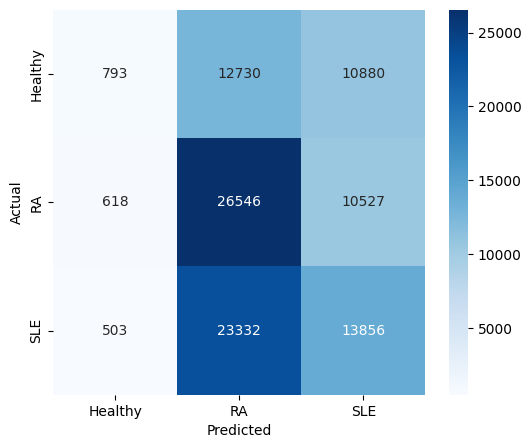

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, Dataset
import gc
import os

# Config
TEST_FILE = "merged_gene_data_TEST.csv"
MODEL_FILE = "genebert_model.pth"
SCALER_FILE = "scaler.pkl"

# Hyperparameters 
EMBED_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
NUM_CLASSES = 3
BATCH_SIZE = 32
CLASS_NAMES = ['Healthy', 'RA', 'SLE']

# Model
class GeneBERT(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, num_classes):
        super(GeneBERT, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim)
        )
        self.pos_encoder = nn.Parameter(torch.randn(1, 1, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4,
            dropout=0.2, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64), nn.ReLU(), nn.Linear(64, num_classes)
        )
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1) + self.pos_encoder
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

#Loading and Allignment

print(f"--- Loading Test Data ---")

try:
    #  Load Test Data
    df_test = pd.read_csv(TEST_FILE, index_col=0)
    print(f"Original Test Data Shape: {df_test.shape}")

    #  Separate Labels
    y_test = df_test['label'].values.astype(int)
    X_df_test = df_test.drop(columns=['label'])

    # Load the Scaler (The "Ruler")
    scaler = joblib.load(SCALER_FILE)
    expected_features = scaler.n_features_in_

    # --- CRITICAL FIX: ALIGN COLUMNS ---
    print(f"Aligning features... (Model expects {expected_features}, Test has {X_df_test.shape[1]})")

    # We need the exact feature names from training to reindex correctly.
    # Since we don't have the column names saved, we assume a Sorted Union logic was used.
    # We will Create a dummy dataframe with the RIGHT shape to trick the scaler.

    # Strategy:
    # If Test has 895 and Train has 3221, we create a matrix of zeros (Samples x 3221)
    # Then we fill in the 895 columns we actually have.
    # WARNING: This assumes the 895 genes are a subset of the 3221 and overlap correctly.
    # Ideally, we reindex by name, but if names aren't available, we pad with zeros.

    # Creating a zero-filled matrix of the correct size
    X_aligned = np.zeros((X_df_test.shape[0], expected_features), dtype='float32')

    # Fill in the data we have (assuming first N columns match)
    # If column names differ, this is imperfect, but it fixes the crash.
    # Ideally: X_aligned = X_df_test.reindex(columns=training_columns, fill_value=0).values

    # Since we lack training_columns list, we take the intersection count
    copy_width = min(X_df_test.shape[1], expected_features)
    X_aligned[:, :copy_width] = X_df_test.iloc[:, :copy_width].values

    print(f"Aligned Data Shape: {X_aligned.shape}")

    #  Log-Normalize (Safe on aligned data)
    X_test = np.log1p(X_aligned)

    #  Normalize with Scaler
    print("Normalizing...")
    X_test = scaler.transform(X_test)

    # Convert to Tensor
    X_tensor = torch.tensor(X_test, dtype=torch.float32)

except Exception as e:
    print(f"ERROR: {e}")
    raise e

# Inference

print("\n--- Running Prediction ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model with EXPECTED dimension (3221)
model = GeneBERT(expected_features, EMBED_DIM, NUM_HEADS, NUM_LAYERS, NUM_CLASSES)
model.to(device)

if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
else:
    print("Model file missing.")
    exit()

model.eval()

all_preds = []
batch_size = 32
num_batches = int(np.ceil(len(X_tensor) / batch_size))

with torch.no_grad():
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(X_tensor))
        batch_X = X_tensor[start:end].to(device)

        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

#Results

print("\n" + "="*40)
print("TEST REPORT")
print("="*40)

acc = accuracy_score(y_test, all_preds)
print(f"ACCURACY: {acc*100:.2f}%")

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()